In [1]:
import cv2
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from skimage import io
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import files
upload_image = files.upload()

In [27]:
left_img = cv2.imread("left_img.jpeg")
right_img = cv2.imread("mid_img.jpeg")
left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

In [28]:
px.imshow(left_img)

In [29]:
px.imshow(right_img)

In [30]:
def make_A(x,y,x_dash,y_dash):
  A = []
  for i in range(4):
    A.append([-x[i],-y[i],-1,0,0,0,x[i]*x_dash[i],y[i]*x_dash[i],x_dash[i]])
    A.append([0,0,0,-x[i],-y[i],-1,x[i]*y_dash[i],y[i]*y_dash[i],y_dash[i]])
  return np.array(A)

In [31]:
def calculate_H(A):
  U, S, Vt = np.linalg.svd(A)
  H = Vt[-1]
  H = np.reshape(H, (3, 3))
  H /= H[2, 2]
  return H

In [33]:
x = [967, 839, 413, 483]
y = [451, 516, 528, 320]
x_dash = [596, 470, 39, 120]
y_dash = [256, 312, 308, 95]

A = make_A(x,y,x_dash,y_dash)
H = calculate_H(A)

In [34]:
for i in range(len(x)):
  left_img = cv2.circle(left_img, (x[i], y[i]), 10, (255, 0, 0), 2)
  right_img = cv2.circle(right_img, (x_dash[i], y_dash[i]), 10, (255, 0, 0), 2)
img1 = px.imshow(left_img)
img2 = px.imshow(right_img)

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "image"}, {"type": "image"}]])

fig.add_trace(
    img1.data[0],
    row=1, col=1
)

fig.add_trace(
    img2.data[0],
    row=1, col=2
)

fig.show()

In [36]:
left_img = cv2.imread("left_img.jpeg")
right_img = cv2.imread("mid_img.jpeg")
left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

In [37]:
def calculate_coordinates(H, img):
  pixel_position = np.array([0, 0, 1])
  up_left = np.dot(H, pixel_position)
  up_left /= up_left[-1]

  pixel_position = np.array([img.shape[1], 0, 1])
  up_right = np.dot(H, pixel_position)
  up_right /= up_right[-1]

  pixel_position = np.array([0, img.shape[0], 1])
  down_left = np.dot(H, pixel_position)
  down_left /= down_left[-1]

  pixel_position = np.array([img.shape[1], img.shape[0], 1])
  down_right = np.dot(H, pixel_position)
  down_right /= down_right[-1]

  height = max(abs(down_left[1] - up_left[1]), abs(down_right[1] - up_right[1]))
  width  = max(abs(up_right[0] - up_left[0]), abs(down_right[0] - down_left[0]))

  return int(height), int(width)

In [38]:
def warp(H, stitched_image, img):
  for j in range(img.shape[0]):
    for i in range(img.shape[1]):
      pixel_position = np.array([i, j, 1])
      new_position = np.dot(H, pixel_position)
      new_position /= new_position[-1]
      if 0 <= new_position[0] <= stitched_image.shape[1] and 0 <= new_position[1] <= stitched_image.shape[0]:
        stitched_image[int(new_position[1]), int(new_position[0]), :] = img[j, i, :]
  return stitched_image

In [39]:
def forward_warp(H, new_img, img, offset1=0, offset2=0):
  for j in range(img.shape[0]):
    for i in range(img.shape[1]):
      pixel_position = np.array([i, j, 1])
      new_position = np.dot(H, pixel_position)
      new_position /= new_position[-1]
      new_img[int(new_position[1])+offset1, int(new_position[0])+offset2, :] = img[j, i, :]
  return new_img

In [155]:
def single_inverse_warp(w, h, c, H_inv, img):
  pixel_position = np.array([w, h, 1])
  original_position = np.dot(H_inv, pixel_position)
  original_position /= original_position[-1]

  P = [[int(np.floor(original_position[0])), int(np.floor(original_position[1]))],
      [int(np.ceil(original_position[0])), int(np.floor(original_position[1]))],
      [int(np.floor(original_position[0])), int(np.ceil(original_position[1]))],
      [int(np.ceil(original_position[0])), int(np.ceil(original_position[1]))]]

  x, y = original_position[0]-P[0][0], original_position[1]-P[0][1]
  W = [(1-x)*(1-y), x*(1-y), (1-x)*y, x*y]

  pixel_value = 0
  for (p, w) in zip(P, W):
    if 0 <= p[0] < img.shape[1] and 0 <= p[1] < img.shape[0]:
      pixel_value += img[p[1], p[0], c] * w

  return pixel_value

In [156]:
def inverse_warp(height, width, H, offset1, offset2, stitched_image, img):
  H_inv = np.linalg.inv(H)
  for i in range(height):
    for j in range(width):
      for k in range(3):
        if stitched_image[i, j, k] == 0:
          pixel_value = single_inverse_warp(j-offset2, i-offset1, k, H_inv, img)
          stitched_image[i, j, k] = int(pixel_value)
  return stitched_image

In [42]:
def overlay(stitched_image, img, offset1=0, offset2=0):
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        # if stitched_image[i, j].any() == 0:
          stitched_image[i+offset1, j+offset2, :] = img[i, j, :]
  return stitched_image

## Projecting left image on right

In [43]:
x = [967, 839, 413, 483]
y = [451, 516, 528, 320]
x_dash = [596, 470, 39, 120]
y_dash = [256, 312, 308, 95]

A = make_A(x,y,x_dash,y_dash)
H = calculate_H(A)

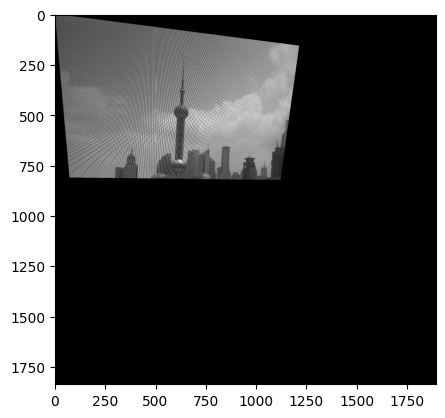

In [44]:
height, width = calculate_coordinates(H, left_img)
stitched_height = height + right_img.shape[1]
stitched_width  = width  + right_img.shape[0]

origin1 = np.dot(H, [0, 0, 1])
origin1 /= origin1[-1]
origin2 = np.dot(H, [0, left_img.shape[0], 1])
origin2 /= origin2[-1]
origin = [min(origin1[0], origin2[0]), origin1[1]]
offset2, offset1 = int(origin[0]*-1), int(origin[1]*-1)

stitched_image = np.zeros((stitched_height, stitched_width, 3), dtype=np.uint8)
stitched_image = forward_warp(H, stitched_image, left_img, offset1, offset2)

plt.imshow(stitched_image);

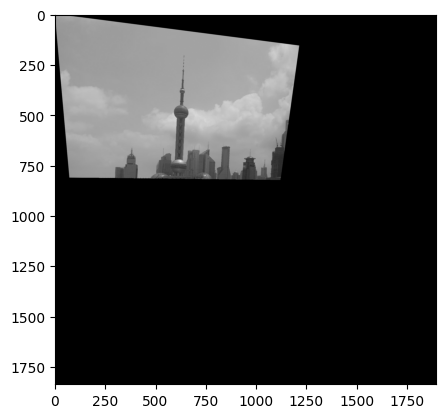

In [45]:
stitched_image = inverse_warp(height, width, H, offset1, offset2, stitched_image, left_img)
plt.imshow(stitched_image);

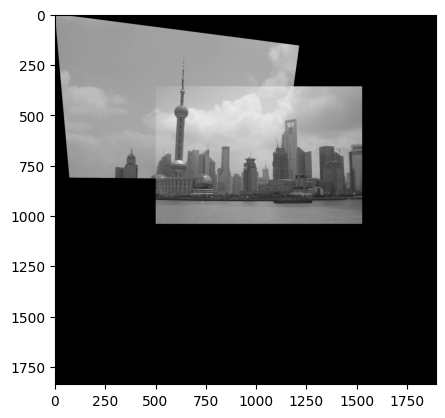

In [46]:
stitched_image = overlay(stitched_image, right_img, offset1, offset2)
plt.imshow(stitched_image);

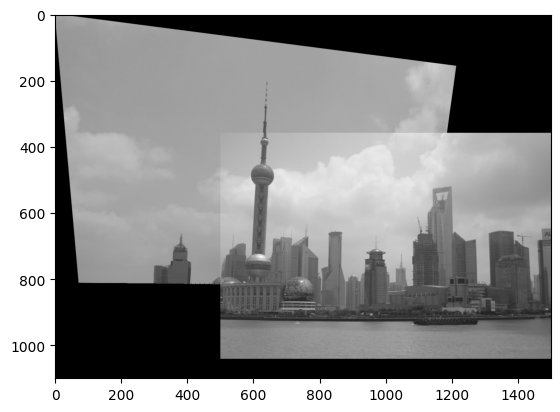

In [47]:
cropped_img = stitched_image[:1100, :1500, :]
plt.imshow(cropped_img);

## Projecting right image on left

In [82]:
left_img = cv2.imread("mid_img.jpeg")
right_img = cv2.imread("right_img.jpeg")
left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

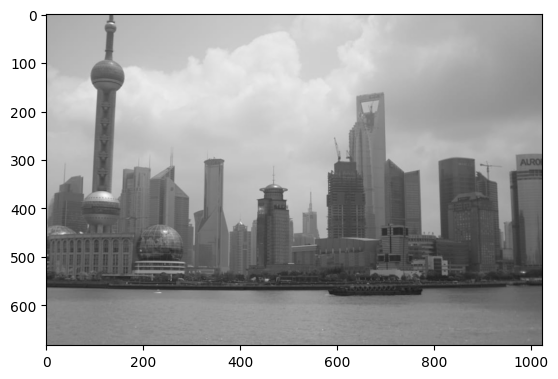

In [83]:
plt.imshow(left_img)

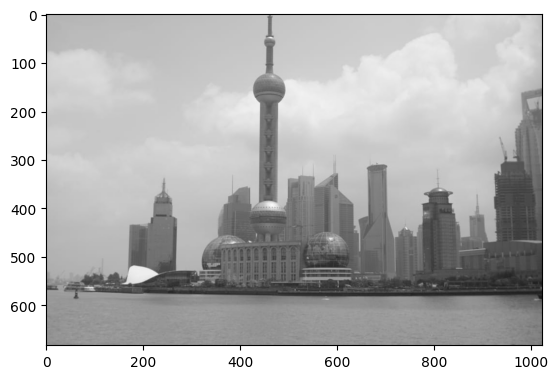

In [84]:
plt.imshow(right_img)

In [85]:
x = [937, 808, 385, 453]
y = [255, 320, 331, 123]
x_dash = [596, 470, 39, 120]
y_dash = [256, 312, 308, 95]

A = make_A(x, y, x_dash, y_dash)
U, S, Vt = np.linalg.svd(A)
H_right = Vt[-1]
H_right = np.reshape(H_right, (3, 3))
H_right /= H_right[2, 2]

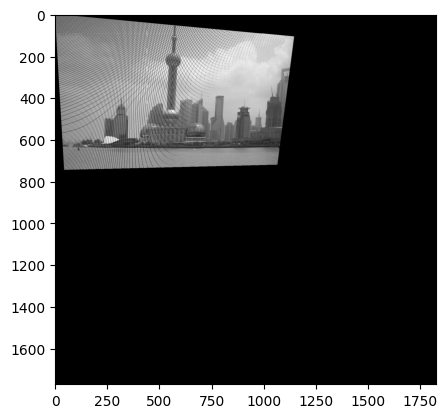

In [86]:
height, width = calculate_coordinates(H_right, right_img)
stitched_height = int(height) + left_img.shape[1]
stitched_width  = int(width)  + left_img.shape[0]

# offset2, offset1 = 0, 0
origin1 = np.dot(H_right, [0, 0, 1])
origin1 /= origin1[-1]
origin2 = np.dot(H_right, [0, right_img.shape[0], 1])
origin2 /= origin2[-1]
origin = [min(origin1[0], origin2[0]), origin1[1]]
offset2, offset1 = int(origin[0]*-1), int(origin[1]*-1)

stitched_image = np.zeros((stitched_height, stitched_width, 3), dtype=np.uint8)
stitched_image = forward_warp(H_right, stitched_image, right_img, offset1, offset2)

plt.imshow(stitched_image);

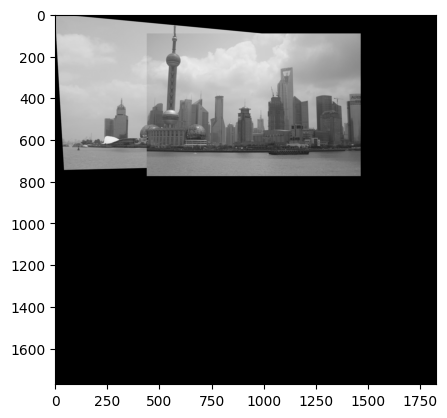

In [87]:
stitched_image = inverse_warp(height, width, H_right, offset1, offset2, stitched_image, right_img)
stitched_image = overlay(stitched_image, left_img, offset1, offset2)

plt.imshow(stitched_image);

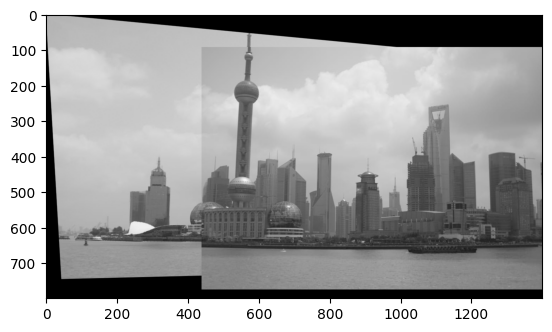

In [88]:
plt.imshow(stitched_image[:800, :1400, :]);

# Bonus Part

In [159]:
upload_image = files.upload()

Saving left_img.jpeg to left_img (1).jpeg
Saving mid_img.jpeg to mid_img (1).jpeg
Saving right_img.jpeg to right_img (1).jpeg


In [160]:
left_img = cv2.imread("left_img.jpeg")
mid_img = cv2.imread("mid_img.jpeg")
right_img = cv2.imread("right_img.jpeg")
left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
mid_img = cv2.cvtColor(mid_img, cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

In [161]:
px.imshow(left_img)

In [162]:
px.imshow(mid_img)

In [163]:
px.imshow(right_img)

In [164]:
# x = [182,249,272,173]
# y = [184,81,189,142]
# x_dash = [11,97,117,6]
# y_dash = [185,76,187,137]

x = [967, 839, 413, 483]
y = [451, 516, 528, 320]
x_dash = [596, 470, 39, 120]
y_dash = [256, 312, 308, 95]

A = make_A(x,y,x_dash,y_dash)
H_left = calculate_H(A)

for i in range(len(x)):
  left_img = cv2.circle(left_img, (x[i], y[i]), 10, (255, 0, 0), 2)
  mid_img = cv2.circle(mid_img, (x_dash[i], y_dash[i]), 10, (255, 0, 0), 2)

# x = [44,140,91,93]
# y = [37,178,256,96]
# x_dash = [254,354,311,299]
# y_dash = [53,190,269,105]

x = [937, 808, 385, 453]
y = [255, 320, 331, 123]
x_dash = [596, 470, 39, 120]
y_dash = [256, 312, 308, 95]

A = make_A(x, y, x_dash, y_dash)
H_right = calculate_H(A)

for i in range(len(x)):
  right_img = cv2.circle(right_img, (x[i], y[i]), 10, (0, 0, 255), 2)
  mid_img = cv2.circle(mid_img, (x_dash[i], y_dash[i]), 10, (0, 0, 255), 2)

img1 = px.imshow(left_img)
img2 = px.imshow(mid_img)
img3 = px.imshow(right_img)

fig = make_subplots(rows=1, cols=3, specs=[[{"type": "image"}, {"type": "image"}, {"type": "image"}]])

fig.add_trace(
    img1.data[0],
    row=1, col=1
)

fig.add_trace(
    img2.data[0],
    row=1, col=2
)

fig.add_trace(
    img3.data[0],
    row=1, col=3
)

fig.show()

In [165]:
left_img = cv2.imread("left_img.jpeg")
mid_img = cv2.imread("mid_img.jpeg")
right_img = cv2.imread("right_img.jpeg")
left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
mid_img = cv2.cvtColor(mid_img, cv2.COLOR_BGR2RGB)
right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)

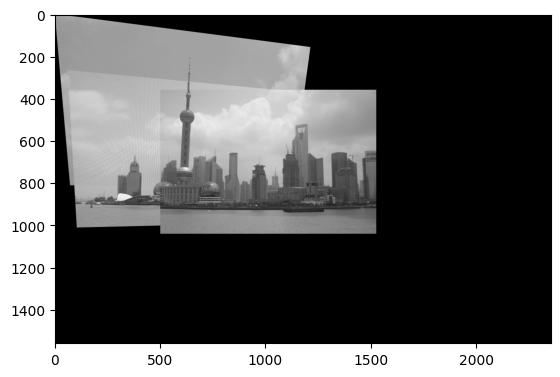

In [166]:
height1, width1 = calculate_coordinates(H_left, left_img)
height2, width2 = calculate_coordinates(H_right, right_img)

stitched_height = height1 + height2
stitched_width  = width1  + width2

# left on top of mid
origin1 = np.dot(H_left, [0, 0, 1])
origin1 /= origin1[-1]
origin2 = np.dot(H_left, [0, left_img.shape[0], 1])
origin2 /= origin2[-1]
origin = [min(origin1[0], origin2[0]), origin1[1]]
offset2, offset1 = int(origin[0]*-1), int(origin[1]*-1)

stitched_image = np.zeros((stitched_height, stitched_width, 3), dtype=np.uint8)
stitched_image = forward_warp(H_left, stitched_image, left_img, offset1, offset2)
stitched_image = inverse_warp(height1, width1, H_left, offset1, offset2, stitched_image, left_img)

stitched_image = forward_warp(H_right, stitched_image, right_img, offset1, offset2)
stitched_image = inverse_warp(stitched_height, stitched_width, H_right, offset1, offset2, stitched_image, right_img)
stitched_image = overlay(stitched_image, mid_img, offset1, offset2)

plt.imshow(stitched_image);

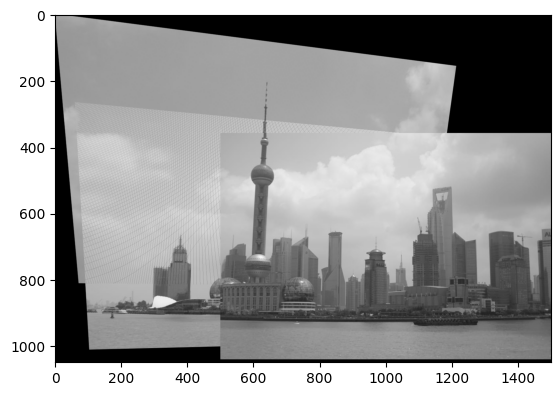

In [167]:
plt.imshow(stitched_image[:1050, :1500, :]);